In [142]:
import torch
import torch.nn as nn
import torch.optim
import numpy as np
import matplotlib.pyplot as plt

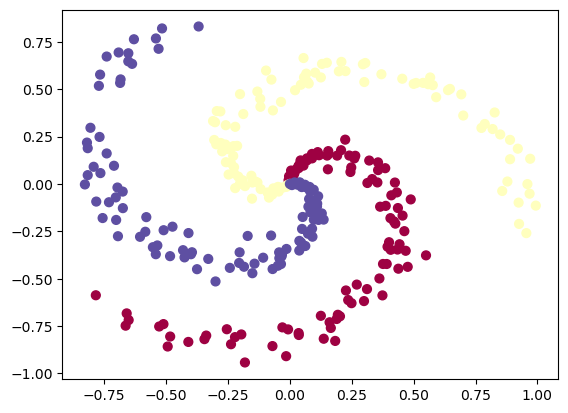

In [143]:
N = 100
D = 2
K = 3
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N)
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [144]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [145]:
device = "mps" if torch.mps.is_available else "cpu"
device

'mps'

In [146]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [147]:
class Model(nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=input, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=output)
        )

    def forward(self, x):
        return self.linear_stack(x)

input = X_train.shape[1]
input

model = Model(input=input, hidden=32, output=4).to(device)
model

Model(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [148]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [149]:
from helper_functions import accuracy_fn

In [150]:
y_test.shape

torch.Size([240])

In [151]:
X_test.shape, y_test.shape

(torch.Size([240, 2]), torch.Size([240]))

In [152]:
torch.manual_seed(42)

epochs = 300

for epoch in range(epochs):
    model.train()
    y_logits_train = model(X_train)
    loss_train = criterion(y_logits_train, y_train)
    y_pred_train = torch.softmax(y_logits_train, dim=1).argmax(dim=1)
    acc_train = accuracy_fn(y_train, y_pred_train)
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    model.eval()
    with torch.inference_mode():
        y_logits_test = model(X_test)
        loss_test = criterion(y_logits_test, y_test)
        y_pred_test = torch.softmax(y_logits_test, dim=1).argmax(dim=1)
        acc_test = accuracy_fn(y_test, y_pred_test)
    
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Training Loss: {loss_train:.2f} | Testing Loss: {loss_test:.2f} | Training Accuracy: {acc_train:.2f} | Testing Accuracy: {acc_test:.2f}')

Epoch: 0 | Training Loss: 1.38 | Testing Loss: 1.33 | Training Accuracy: 16.67 | Testing Accuracy: 37.92
Epoch: 10 | Training Loss: 0.95 | Testing Loss: 0.95 | Training Accuracy: 61.67 | Testing Accuracy: 60.00
Epoch: 20 | Training Loss: 0.67 | Testing Loss: 0.72 | Training Accuracy: 73.33 | Testing Accuracy: 59.17
Epoch: 30 | Training Loss: 0.54 | Testing Loss: 0.62 | Training Accuracy: 70.00 | Testing Accuracy: 58.75
Epoch: 40 | Training Loss: 0.43 | Testing Loss: 0.51 | Training Accuracy: 71.67 | Testing Accuracy: 68.75
Epoch: 50 | Training Loss: 0.35 | Testing Loss: 0.40 | Training Accuracy: 76.67 | Testing Accuracy: 79.17
Epoch: 60 | Training Loss: 0.27 | Testing Loss: 0.30 | Training Accuracy: 86.67 | Testing Accuracy: 85.83
Epoch: 70 | Training Loss: 0.20 | Testing Loss: 0.23 | Training Accuracy: 91.67 | Testing Accuracy: 90.83
Epoch: 80 | Training Loss: 0.16 | Testing Loss: 0.19 | Training Accuracy: 93.33 | Testing Accuracy: 92.50
Epoch: 90 | Training Loss: 0.14 | Testing Loss:

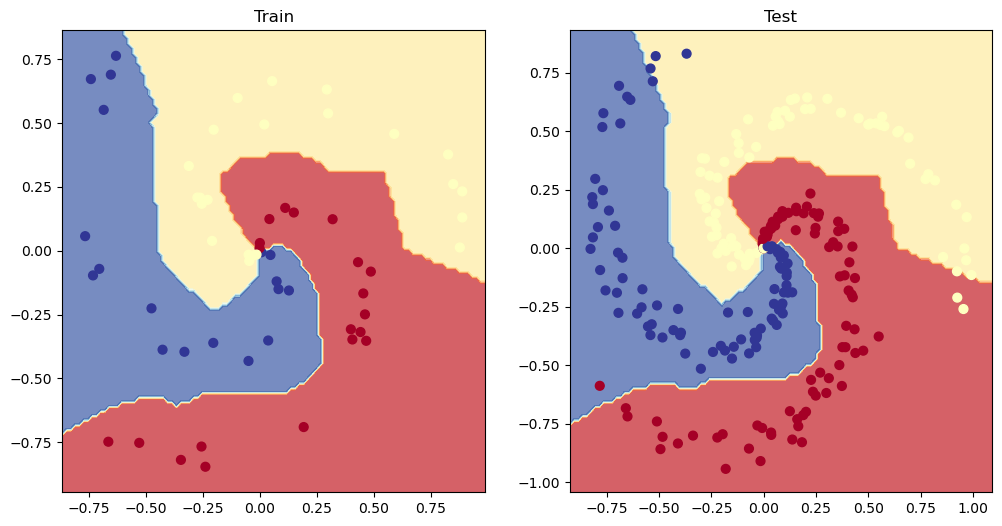

In [153]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)